# Making predictions on Protegrin-1 mutants 

Here is the procedure used to predicty activity, selectivity and hemolysis in all possible single, double, and triple mutants of protegrin-1. 

In [2]:
import os
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3, venn3_unweighted, venn2_unweighted
from sklearn import metrics

pd.set_option('display.max_columns', 100)

%matplotlib inline

In [2]:
# Load the pickled model trained only on protegrin variants 

# model trained on MBC data
model_GNB_mbc = pickle.load(open('models/model_GNB_esm2_15B_MBC_classification.pkl', 'rb'))

# model trained on hemolysis data
model_SVR_hemo = pickle.load(open('models/model_SVR_esm2_15B_Hemo_regression_corr06.pkl', 'rb'))
corr_columns_hemo = pickle.load(open('models/correlated_columns_esm2_15B_hemolysis_corr06.pkl', 'rb'))

# model to predict selectivity
model_SVR_sel = pickle.load(open('models/model_SVR_esm2_15B_SEL_regression_corr06.pkl', 'rb'))
corr_columns_sel = pickle.load(open('models/correlated_columns_esm2_15B_SEL_corr06.pkl', 'rb'))

## Predictions on single mutation Protegrin-1 Variants

In [3]:
# load meta_data with mutations on PG1
meta_data = pd.read_csv('data/protegrin_variants_1mut.csv', index_col=0)
meta_data

,ID,Sequence
0,1mut_0,RGGRLCYCRRRFCVLVGR
1,1mut_1,RMGRLCYCRRRFCVCVGR
2,1mut_2,RGGRLCYCRRRFCVCVFR
3,1mut_3,EGGRLCYCRRRFCVCVGR
4,1mut_4,RGGNLCYCRRRFCVCVGR
...,...,...
338,1mut_338,RGGRLCYSRRRFCVCVGR
339,1mut_339,RGGRLCYCRRKFCVCVGR
340,1mut_340,RGGRLCHCRRRFCVCVGR
341,1mut_341,RGGRLCYCRRDFCVCVGR


In [4]:
######################## Load the embedding ######################
# since those embeddings are too large, I saved them in a separate file

# dir_path = 'data/embedding/esm2_15B_pg1_1mut/'
# embeddings = {}
# for file in os.listdir(dir_path):
#         file_path = str(dir_path) + file 
#         label = file.split('.pt')[0]
#         embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])


# # merge embeddings with metadata
# df = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)

# df.to_pickle('data/embedding/esm2_15B_pg1_1mut.pkl')
#df

In [5]:
# load embeddings from a pickle file
df = pd.read_pickle('data/embedding/esm2_15B_pg1_1mut.pkl')
df

,ID,Sequence,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,1mut_0,RGGRLCYCRRRFCVLVGR,0.139956,-0.125581,-0.076405,0.146426,-0.280027,0.177829,-0.103134,0.157826,-0.095869,0.238305,-0.166609,-0.106000,0.197645,0.147172,0.172095,-0.173993,0.049640,-0.142380,0.071343,-0.033491,0.175970,0.044800,-0.230723,0.116288,-0.228306,-0.045376,0.081696,-0.078286,0.017577,0.161617,-0.144766,-0.046883,-0.329819,-0.064292,-0.049258,0.030661,0.182056,-0.066748,0.331273,-0.024626,0.153560,-0.341233,0.098469,0.041766,-0.098336,0.335028,0.060487,0.080803,...,-0.290288,-0.138646,0.337517,-0.036846,-0.145865,0.145739,-0.013954,-0.022534,0.266587,0.210630,-0.026933,0.026307,0.076589,0.187688,0.110229,-0.061802,-0.139272,0.225796,-0.113380,-0.024664,-0.230150,-0.086779,-0.018946,-0.150796,0.282690,0.062186,0.217737,0.001308,-0.076220,0.029293,0.134988,0.126751,-0.051001,-0.078870,-0.066645,-0.088527,-0.066581,-0.284267,-0.055163,0.033041,-0.139801,-0.113517,0.121989,-0.190335,0.056447,-0.192906,0.056169,-0.037111,-0.264767,0.061206
1,1mut_1,RMGRLCYCRRRFCVCVGR,0.130926,0.000480,-0.139269,0.132204,-0.236016,0.171966,-0.085120,0.153231,-0.031941,0.153898,-0.142295,-0.114512,0.133251,0.141893,0.076887,-0.163610,0.135277,-0.086710,0.105006,0.039981,0.171417,-0.014597,-0.170309,0.056443,-0.123541,-0.021217,0.097796,-0.054952,0.091123,0.158605,-0.163539,-0.032665,-0.253657,-0.142816,-0.084620,0.004738,0.186130,-0.062229,0.138385,-0.051106,0.132185,-0.129907,0.131162,0.019662,-0.074399,0.299450,0.103770,0.101100,...,-0.303995,-0.181548,0.189195,-0.035498,-0.048187,0.136608,-0.038978,0.003040,0.180409,0.252026,-0.034072,0.067309,0.028784,0.119834,0.231834,-0.008835,-0.155341,0.164639,-0.088200,-0.141192,-0.107459,-0.126025,-0.100561,-0.043595,0.288866,-0.020607,0.087057,-0.002016,-0.042150,0.094406,0.091099,0.142107,-0.021993,-0.063503,0.044875,0.009611,-0.126196,-0.259387,-0.037057,0.041199,-0.139124,-0.158397,0.033567,-0.222891,0.147657,-0.210249,-0.039008,-0.049254,-0.220128,0.026089
2,1mut_2,RGGRLCYCRRRFCVCVFR,0.122494,0.015151,-0.113578,0.147190,-0.248815,0.153636,-0.082545,0.143023,-0.032666,0.198368,-0.141825,-0.072487,0.164319,0.155215,0.000999,-0.142618,0.028556,-0.091350,0.169577,-0.013866,0.158021,-0.034980,-0.236284,0.121333,-0.169987,0.009360,0.132464,-0.091888,0.103464,0.148294,-0.164126,-0.009009,-0.292603,-0.130214,-0.137328,0.002338,0.152275,-0.041424,0.209629,-0.034807,0.131335,-0.169956,0.116559,0.063441,-0.047805,0.292008,0.127569,0.090374,...,-0.341078,-0.151316,0.166382,-0.083772,-0.031800,0.173639,-0.039404,-0.026641,0.183440,0.283105,-0.058492,0.033385,0.051223,0.157715,0.203213,-0.015537,-0.231012,0.176929,-0.108814,-0.151691,-0.155576,-0.138166,-0.069419,-0.081773,0.287196,-0.045575,0.097953,-0.033838,-0.036365,0.125570,0.049084,0.162091,0.003630,-0.094018,-0.003765,0.019716,-0.172657,-0.253969,-0.060248,0.032126,-0.131952,-0.182381,0.012476,-0.216764,0.082182,-0.167000,0.017850,-0.070759,-0.238455,0.011200
3,1mut_3,EGGRLCYCRRRFCVCVGR,0.137794,-0.026297,-0.100598,0.132454,-0.240978,0.123862,-0.108370,0.163518,-0.074148,0.135701,-0.147309,-0.161241,0.135352,0.173438,0.115235,-0.128381,0.062604,-0.100330,0.103954,0.043673,0.147754,0.030620,-0.217643,0.078211,-0.180088,-0.034668,0.076345,-0.030924,0.068764,0.133319,-0.132511,-0.038674,-0.252596,-0.127496,-0.098959,0.027856,0.196983,-0.067005,0.181675,-0.063434,0.197272,-0.178226,0.124807,0.080779,-0.057945,0.309352,0.085288,0.077937,...,-0.238969,-0.153715,0.178666,-0.043892,-0.123913,0.146099,-0.052013,-0.003793,0.247806,0.245565,-0.039263,0.074070,0.054889,0.122570,0.174041,-0.029537,-0.161622,0.190393,-0.111680,-0.081653,-0.096576,-0.078513,-0.077

## Predicting active variants with AMP MBC <= 8

In [6]:
features = df.iloc[:,2:]
features.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.139956,-0.125581,-0.076405,0.146426,-0.280027,0.177829,-0.103134,0.157826,-0.095869,0.238305,-0.166609,-0.106000,0.197645,0.147172,0.172095,-0.173993,0.049640,-0.142380,0.071343,-0.033491,0.175970,0.044800,-0.230723,0.116288,-0.228306,-0.045376,0.081696,-0.078286,0.017577,0.161617,-0.144766,-0.046883,-0.329819,-0.064292,-0.049258,0.030661,0.182056,-0.066748,0.331273,-0.024626,0.153560,-0.341233,0.098469,0.041766,-0.098336,0.335028,0.060487,0.080803,-0.175508,0.016926,...,-0.290288,-0.138646,0.337517,-0.036846,-0.145865,0.145739,-0.013954,-0.022534,0.266587,0.210630,-0.026933,0.026307,0.076589,0.187688,0.110229,-0.061802,-0.139272,0.225796,-0.113380,-0.024664,-0.230150,-0.086779,-0.018946,-0.150796,0.282690,0.062186,0.217737,0.001308,-0.076220,0.029293,0.134988,0.126751,-0.051001,-0.078870,-0.066645,-0.088527,-0.066581,-0.284267,-0.055163,0.033041,-0.139801,-0.113517,0.121989,-0.190335,0.056447,-0.192906,0.056169,-0.037111,-0.264767,0.061206
1,0.130926,0.000480,-0.139269,0.132204,-0.236016,0.171966,-0.085120,0.153231,-0.031941,0.153898,-0.142295,-0.114512,0.133251,0.141893,0.076887,-0.163610,0.135277,-0.086710,0.105006,0.039981,0.171417,-0.014597,-0.170309,0.056443,-0.123541,-0.021217,0.097796,-0.054952,0.091123,0.158605,-0.163539,-0.032665,-0.253657,-0.142816,-0.084620,0.004738,0.186130,-0.062229,0.138385,-0.051106,0.132185,-0.129907,0.131162,0.019662,-0.074399,0.299450,0.103770,0.101100,-0.090511,0.077786,...,-0.303995,-0.181548,0.189195,-0.035498,-0.048187,0.136608,-0.038978,0.003040,0.180409,0.252026,-0.034072,0.067309,0.028784,0.119834,0.231834,-0.008835,-0.155341,0.164639,-0.088200,-0.141192,-0.107459,-0.126025,-0.100561,-0.043595,0.288866,-0.020607,0.087057,-0.002016,-0.042150,0.094406,0.091099,0.142107,-0.021993,-0.063503,0.044875,0.009611,-0.126196,-0.259387,-0.037057,0.041199,-0.139124,-0.158397,0.033567,-0.222891,0.147657,-0.210249,-0.039008,-0.049254,-0.220128,0.026089
2,0.122494,0.015151,-0.113578,0.147190,-0.248815,0.153636,-0.082545,0.143023,-0.032666,0.198368,-0.141825,-0.072487,0.164319,0.155215,0.000999,-0.142618,0.028556,-0.091350,0.169577,-0.013866,0.158021,-0.034980,-0.236284,0.121333,-0.169987,0.009360,0.132464,-0.091888,0.103464,0.148294,-0.164126,-0.009009,-0.292603,-0.130214,-0.137328,0.002338,0.152275,-0.041424,0.209629,-0.034807,0.131335,-0.169956,0.116559,0.063441,-0.047805,0.292008,0.127569,0.090374,-0.093007,-0.003598,...,-0.341078,-0.151316,0.166382,-0.083772,-0.031800,0.173639,-0.039404,-0.026641,0.183440,0.283105,-0.058492,0.033385,0.051223,0.157715,0.203213,-0.015537,-0.231012,0.176929,-0.108814,-0.151691,-0.155576,-0.138166,-0.069419,-0.081773,0.287196,-0.045575,0.097953,-0.033838,-0.036365,0.125570,0.049084,0.162091,0.003630,-0.094018,-0.003765,0.019716,-0.172657,-0.253969,-0.060248,0.032126,-0.131952,-0.182381,0.012476,-0.216764,0.082182,-0.167000,0.017850,-0.070759,-0.238455,0.011200
3,0.137794,-0.026297,-0.100598,0.132454,-0.240978,0.123862,-0.108370,0.163518,-0.074148,0.135701,-0.147309,-0.161241,0.135352,0.173438,0.115235,-0.128381,0.062604,-0.100330,0.103954,0.043673,0.147754,0.030620,-0.217643,0.078211,-0.180088,-0.034668,0.076345,-0.030924,0.068764,0.133319,-0.132511,-0.038674,-0.252596,-0.127496,-0.098959,0.027856,0.196983,-0.067005,0.181675,-0.063434,0.197272,-0.178226,0.124807,0.080779,-0.057945,0.309352,0.085288,0.077937,-0.118641,0.097144,...,-0.238969,-0.153715,0.178666,-0.043892,-0.123913,0.146099,-0.052013,-0.003793,0.247806,0.245565,-0.039263,0.074070,0.054889,0.122570,0.174041,-0.029537,-0.161622,0.190393,-0.111680,-0.081653,-0.096576,-0.078513,-0.077252,-0.082461,0.261394,0.016504,0

In [7]:
# creates a df to save probabilities
res_GNB = df.iloc[:,0:1].copy()

# calculates the probability of being active
prob= model_GNB_mbc.predict_proba(features)
prob= [(x[1]*100).round(2) for x in prob]

res_GNB['MBC_8_prob']=prob

#number of peptides with probability == 100%
print(f"{res_GNB.query('MBC_8_prob == 100').shape[0]} peptides with probability == 100% to be active")

223 peptides with probability == 100% to be active


### Predicting selectivity score

In [8]:
features2 = features[corr_columns_sel]
features2.head()

,2666,5111,3870,1016,3386,4435,815,1672,5077,2693,1586,1736,248,2623,45,4507,3448,4207,4779,3321,2067,1944,3718,1633,1261,620,2985,4955,3562,3128,2856,4664,250,156,1487,3284,4948,3012,4402,1537,4831,4642,4943,5002,487,4320,1571,1745,254,3731,...,4467,197,2530,1645,4617,3668,2917,1658,3758,4385,4602,4603,1336,2045,2231,3033,3135,1194,1012,1603,2983,2307,5040,4936,3896,2990,2560,646,1994,4667,4885,4691,122,4514,1757,472,4118,4672,365,507,3863,332,4468,1876,2290,312,3895,4707,1739,609
0,0.138205,-0.113517,0.108182,-0.038399,0.107732,-0.038690,-0.056447,-0.178459,-0.022534,-0.192194,0.184653,0.063734,0.260358,0.133888,0.335028,-0.132767,0.095069,-0.113563,-0.195331,-0.034082,-0.083275,-0.089450,-0.090117,-0.020732,-0.143298,-0.030247,0.204233,-0.096451,0.171133,0.249626,0.104122,-0.057424,-0.049681,-0.273808,0.100181,0.001749,-0.120265,-0.050387,-0.046740,-0.083215,-0.050825,-0.043062,-0.079924,0.118083,0.188541,-0.213870,0.011973,0.133357,-0.127766,0.072488,...,-0.009536,-0.022343,0.219287,0.064210,0.115093,0.279339,0.157045,0.098685,-0.201618,0.000320,0.081344,-0.198953,0.089451,0.095624,-0.059913,0.100969,-0.062157,0.082203,0.044195,-0.258994,-0.134178,-0.171858,-0.000299,0.076435,0.005795,0.211681,-0.235236,0.272669,0.227568,0.152122,0.083098,-0.055522,-0.129875,-0.325801,0.143856,-0.177722,-0.060929,-0.043930,-0.133377,-0.048106,0.016473,-0.127265,-0.336973,0.321159,0.079548,-0.098713,0.128183,0.083653,-0.139789,-0.057011
1,-0.020206,-0.158397,0.135008,0.003020,0.158953,-0.010583,-0.031622,-0.138203,0.003040,-0.091262,0.243829,0.003816,0.139897,0.110006,0.299450,-0.068998,0.021804,-0.049925,-0.138369,-0.050757,0.013657,-0.049736,-0.064453,0.070847,-0.056336,0.020615,0.136305,-0.162165,-0.015475,0.157115,0.051188,-0.123188,-0.003691,-0.236020,-0.018277,0.055421,0.036691,-0.168769,-0.160793,-0.025361,-0.049056,0.050471,-0.132368,0.198355,0.155844,-0.131049,0.075615,0.062675,-0.180463,-0.023789,...,-0.001940,-0.169353,0.167552,0.022303,0.034722,0.153149,0.238943,0.020760,-0.138471,0.016244,0.036889,-0.028441,0.143387,0.011238,-0.126368,-0.013882,0.040844,0.093544,0.105810,-0.194733,-0.137941,-0.075150,0.037642,-0.028179,0.040785,0.118771,-0.233748,0.195092,0.317833,0.241090,-0.003912,-0.108124,-0.017604,-0.277303,-0.028060,-0.106809,-0.145703,0.033320,-0.050371,-0.056348,-0.012693,-0.078862,-0.216888,0.214837,0.078916,-0.020273,0.019695,0.032632,-0.075977,-0.035800
2,0.036062,-0.182381,0.185465,0.046625,0.125700,-0.026314,-0.052663,-0.110121,-0.026641,-0.106113,0.246068,-0.026034,0.181103,0.049459,0.292008,-0.139026,0.026789,-0.058743,-0.145672,-0.086902,0.005703,-0.010652,-0.035127,0.074633,-0.113096,0.100700,0.135875,-0.152971,0.031064,0.203057,0.013377,-0.142064,0.070643,-0.194992,0.008819,0.059414,0.066705,-0.141808,-0.200058,-0.099021,-0.035943,0.039593,-0.135064,0.231467,0.134776,-0.130498,0.075873,0.060558,-0.262258,-0.032008,...,0.056658,-0.186726,0.167296,0.043760,0.033992,0.174312,0.214022,0.020557,-0.178318,0.082250,-0.002072,-0.083313,0.116200,0.036274,-0.110983,0.014452,0.023283,0.046362,0.102304,-0.233575,-0.166962,-0.101392,0.044689,0.004643,0.037434,0.061816,-0.224664,0.226329,0.329537,0.219400,0.002511,-0.073100,-0.010096,-0.243607,-0.019194,-0.137208,-0.153534,0.059173,-0.020794,-0.072596,-0.083802,-0.085990,-0.225501,0.271957,0.047683,-0.020943,-0.001894,0.033557,-0.087866,0.057719
3,-0.005692,-0.175840,0.171891,0.015688,0.105029,-0.018136,-0.050024,-0.133041,-0.003793,-0.128638,0.183705,0.034678,0.164800,0.122060,0.309352,-0.106624,0.031861,-0.097653,-0.152417,-0.047235,0.008589,-0.027220,-0.077713,0.049397,-0.071824,0.042089,0.159370,-0.137566,0.036457,0.208632,0.072112,-0.079216,-0.027428,-0.203245,0.029432,0.107756,0.003219,-0.100135,-0.151231,-0.022948,-0.080574,0.041737,-0.106501,0.175616,0.153913,-0.121165,0.026955,0.060969,-0.183919,0.014999,...,0.026619,-0.144703,0.220331,0.036872,0.047528,0.160587,0.204531,0.073986,-0.170452,0.009505,-0.006261,-0.087972,0.120044,0.058955,-0.131791,-0.021566,0.025783,

In [9]:
# creates a df to selectivity score
res_sel = df.iloc[:,0:1].copy()

# calculates the the selectivity score
prob= model_SVR_sel.predict(features2)
res_sel['selectivity_pred']= prob.round(2) 

#number of peptides with selectivity score < 0.5
print(f"{res_sel.query('selectivity_pred < 0.5').shape[0]} peptides with selectivity score < 0.5")

0 peptides with selectivity score < 0.5


### Prediction of Hemolysis % to protegrin-1 variants

In [10]:
features3 = features[corr_columns_hemo]
features3.head()

,3596,3197,3257,868,182,3775,3448,1777,4693,803,4459,2490,4396,2673,3179,838,310,3006,1198,3135,964,4539,2917,4277,2580,912,1901,3599,4514,2382,2714,2772,2233,3878,3318,4299,506,3520,4442,3032,4672,3942,5089,2985,2964,4161,657,3701,2111,2400,...,809,2826,1739,4011,914,4531,4537,2492,2990,3718,3427,177,4402,2939,122,1935,1370,783,4926,4623,609,4686,2093,3033,1487,4885,3399,2045,2607,1012,4603,2267,1757,2951,4040,933,2067,1273,4642,1336,197,4948,3891,646,935,365,1586,2210,4468,3586
0,-0.152785,-0.145927,0.013457,-0.174610,0.071494,0.103510,0.095069,-0.890151,0.282905,-0.120841,0.113340,0.045056,0.261291,-0.055778,-0.151079,0.038528,0.169028,0.165485,0.010659,-0.062157,0.070706,-0.218399,0.157045,-0.075829,0.160154,-0.079815,-0.186775,0.020245,-0.325801,0.076273,-0.051162,-0.015495,0.043278,-0.136133,0.437702,-0.049228,-0.211004,-0.008260,-0.065269,-0.028814,-0.043930,-0.078187,-0.024664,0.204233,0.058046,0.159859,0.102217,-0.074190,-0.111635,-0.038382,...,0.170391,-0.167059,-0.139789,-0.138290,0.151943,0.138278,0.077812,0.076805,0.211681,-0.090117,0.040830,0.215925,-0.046740,-0.063050,-0.129875,-0.071333,-0.098315,-0.057562,-0.089523,0.145655,-0.057011,0.048576,-0.068355,0.100969,0.100181,0.083098,0.000218,0.095624,-0.430121,0.044195,-0.198953,-0.204953,0.143856,-0.005251,-0.099890,-0.045577,-0.083275,0.140286,-0.043062,0.089451,-0.022343,-0.120265,0.154824,0.272669,-0.051211,-0.133377,0.184653,-0.116951,-0.336973,0.003744
1,-0.051140,0.049166,-0.145489,-0.100902,0.030177,0.145114,0.021804,-0.663329,0.389468,0.039659,0.045833,-0.080914,0.191462,-0.190126,-0.037042,0.144452,0.114726,0.025019,-0.086013,0.040844,0.155991,-0.255491,0.238943,-0.086763,0.232387,-0.167485,-0.124903,0.054908,-0.277303,-0.096228,0.120021,-0.103544,0.179608,-0.132286,0.391408,-0.181494,-0.017136,-0.113410,0.004597,0.063529,0.033320,-0.076833,-0.141192,0.136305,0.073642,0.044347,-0.031266,-0.202569,-0.071652,0.051839,...,0.109096,-0.073628,-0.075977,-0.189613,0.102269,0.013030,-0.052914,-0.095291,0.118771,-0.064453,-0.075250,0.178879,-0.160793,0.155203,-0.017604,-0.021226,-0.041966,0.056716,0.022190,0.224679,-0.035800,0.172737,0.085485,-0.013882,-0.018277,-0.003912,0.126776,0.011238,-0.371703,0.105810,-0.028441,-0.297348,-0.028060,0.068798,-0.035327,-0.111541,0.013657,0.021559,0.050471,0.143387,-0.169353,0.036691,0.252215,0.195092,-0.128424,-0.050371,0.243829,-0.010017,-0.216888,0.062844
2,-0.073152,0.038004,-0.184702,-0.103581,0.050502,0.220941,0.026789,-0.688115,0.414197,0.035726,-0.023893,-0.061107,0.186343,-0.153117,-0.042783,0.136877,0.108790,0.065939,-0.072926,0.023283,0.125004,-0.274344,0.214022,-0.074913,0.242312,-0.171245,-0.117793,0.056812,-0.243607,-0.066368,0.078191,-0.153893,0.108461,-0.095438,0.412884,-0.131509,-0.044235,-0.052209,-0.010987,0.030279,0.059173,-0.059329,-0.151691,0.135875,0.053022,0.047950,0.006144,-0.184348,-0.073507,0.049595,...,0.092241,-0.071105,-0.087866,-0.239348,0.129282,0.031106,-0.057831,-0.103320,0.061816,-0.035127,-0.103785,0.111111,-0.200058,0.183560,-0.010096,0.030091,-0.056969,0.080561,-0.052626,0.185849,0.057719,0.158811,0.137320,0.014452,0.008819,0.002511,0.134488,0.036274,-0.340766,0.102304,-0.083313,-0.311183,-0.019194,0.068406,-0.034635,-0.120600,0.005703,0.083902,0.039593,0.116200,-0.186726,0.066705,0.271434,0.226329,-0.122072,-0.020794,0.246068,-0.027105,-0.225501,0.056378
3,-0.068811,-0.028633,-0.099668,-0.130831,0.061104,0.108426,0.031861,-0.652215,0.383357,-0.005347,0.009728,-0.029773,0.200871,-0.157701,-0.073374,0.115405,0.120759,0.049670,-0.074517,0.025783,0.130788,-0.267953,0.204531,-0.106480,0.193606,-0.127501,-0.154276,0.035853,-0.277580,-0.053531,0.060352,-0.115214,0.084542,-0.103711,0.372206,-0.141950,-0.067476,-0.109010,-0.038822,0.037598,0.026848,-0.093853,-0.081653,0.159370,0.067296,0.077412,0.006068,-0.132326,-0.075167,0.051569,...,0.122895,-0.073863,-0.116467,-0.183481,0.119329,0.016429,-0.015311,-0.002207,0.161175,-0.077713,-0.094587,0.181260,-0.151231,0.112114,-0.059679,-0.040865,-0.102109,

In [11]:
# creates a df to save hemolysis score
res_hemo = df.iloc[:,0:1].copy()

# calculates the the hemolysis score
pred= model_SVR_hemo.predict(features3)
res_hemo['hemolysis_pred']= pred.round(2)

#number of peptides with hemolysis score < 1
print(f"{res_hemo.query('hemolysis_pred <= 2').shape[0]} peptides with predicted hemolysis% < 2%")

8 peptides with predicted hemolysis% < 2%


## Results of single mutant

In [12]:
results = res_GNB.merge(res_sel[['ID', 'selectivity_pred']], how='inner', left_on='ID', right_on='ID')
results = results.merge(res_hemo[['ID', 'hemolysis_pred']], how='inner', left_on='ID', right_on='ID')
results = meta_data.merge(results, how='inner', left_on='ID', right_on='ID')
results

,ID,Sequence,MBC_8_prob,selectivity_pred,hemolysis_pred
0,1mut_0,RGGRLCYCRRRFCVLVGR,100.0,1.71,8.30
1,1mut_1,RMGRLCYCRRRFCVCVGR,100.0,2.35,34.50
2,1mut_2,RGGRLCYCRRRFCVCVFR,0.0,2.89,39.31
3,1mut_3,EGGRLCYCRRRFCVCVGR,100.0,2.31,30.70
4,1mut_4,RGGNLCYCRRRFCVCVGR,100.0,2.32,32.25
...,...,...,...,...,...
338,1mut_338,RGGRLCYSRRRFCVCVGR,100.0,2.89,13.00
339,1mut_339,RGGRLCYCRRKFCVCVGR,100.0,2.23,32.72
340,1mut_340,RGGRLCHCRRRFCVCVGR,100.0,1.65,17.53
341,1mut_341,RGGRLCYCRRDFCVCVGR,100.0,2.25,25.78


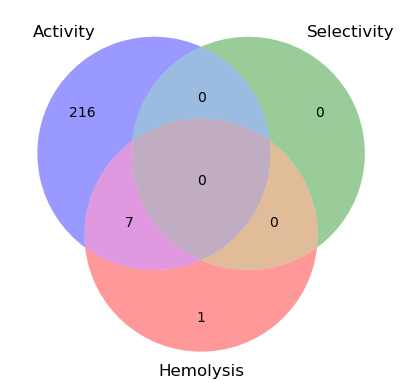

In [13]:
# Define the sets as lists of elements
set1 = set(results.query('MBC_8_prob == 100')['ID'].values)
set2 = set(results.query('selectivity_pred < 0.5')['ID'].values)
set3 = set(results.query('hemolysis_pred <= 2')['ID'].values)


# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
#plt.savefig('MBC_HEMO_SEL_2mut_venn3_predictions_v03.png')
plt.show()

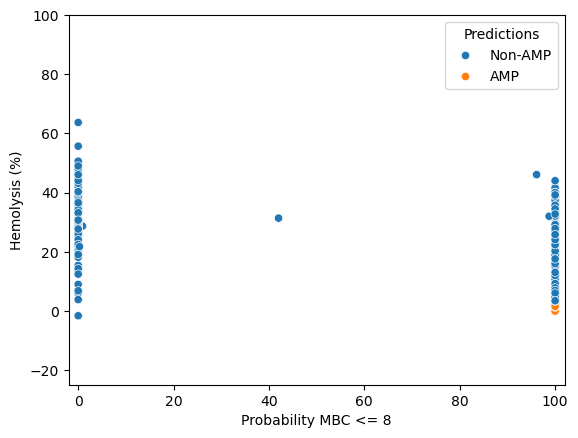

In [14]:
color1 = results.apply(lambda x: 'AMP' if x['MBC_8_prob'] > 90 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='MBC_8_prob', y='hemolysis_pred', hue=color1)
plt.xlabel('Probability MBC <= 8')
plt.ylabel('Hemolysis (%)')
plt.legend(loc='upper center')
plt.legend(title= "Predictions")
plt.ylim(-25,100)
plt.xlim(-2,102)
plt.show()

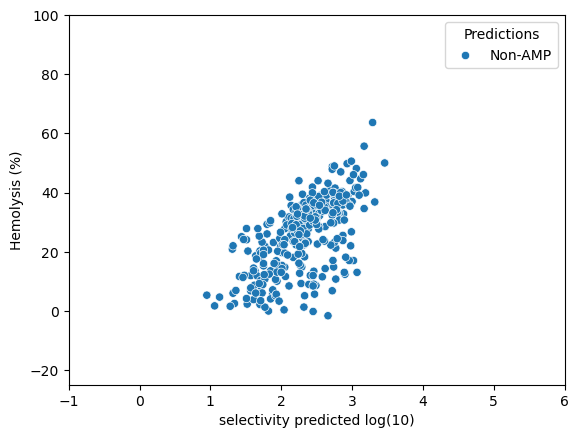

In [15]:
color2 = results.apply(lambda x: 'AMP' if x['selectivity_pred'] < 1 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='selectivity_pred', y='hemolysis_pred', hue=color2)
plt.ylabel('Hemolysis (%)')
plt.xlabel('selectivity predicted log(10)')
plt.legend(loc='upper right')
plt.ylim(-25,100)
plt.xlim(-1,6)
plt.legend(title= "Predictions")
plt.show()

In [16]:
# saving results
#results.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1mut.csv')

## Predictions on double mutation Protegrin-1 Variants

In [17]:
# load meta_data with mutations on PG1
meta_data = pd.read_csv('data/protegrin_variants_2mut.csv', index_col=0)
meta_data

,ID,Sequence
0,2mut_0,RGPRLCYCRRRQCVCVGR
1,2mut_1,YGGPLCYCRRRFCVCVGR
2,2mut_2,RKGRLCGCRRRFCVCVGR
3,2mut_3,RGGRLCYCRRWFCVKVGR
4,2mut_4,RGGRLCYCMRRFCVCDGR
...,...,...
55571,2mut_55571,CGGRLCYCRRRWCVCVGR
55572,2mut_55572,RGGRLCYCRRRHDVCVGR
55573,2mut_55573,RGGRMCYCRRRFCVCVAR
55574,2mut_55574,RGGRLCYCRIRFIVCVGR


In [18]:
######################## Load the embedding ######################
# since those embeddings are too large, I saved them in a separate file

# dir_path = '/stor/work/Wilke/luiz/ML_PG1/embeddings/esm2_15B_pg1_2mut/'
# embeddings = {}
# for file in os.listdir(dir_path):
#         file_path = str(dir_path) + file 
#         label = file.split('.pt')[0]
#         embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])


# # merge embeddings with metadata
# df = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)

# df.to_pickle('data/embedding/esm2_15B_pg1_2mut.pkl')

In [19]:
# load embeddings from a pickle file
df = pd.read_pickle(f'data/embedding/esm2_15B_pg1_2mut.pkl')
df

,ID,Sequence,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,...,5070,5071,5072,5073,5074,5075,5076,5077,5078,5079,5080,5081,5082,5083,5084,5085,5086,5087,5088,5089,5090,5091,5092,5093,5094,5095,5096,5097,5098,5099,5100,5101,5102,5103,5104,5105,5106,5107,5108,5109,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,2mut_0,RGPRLCYCRRRQCVCVGR,0.030471,-0.036276,-0.111070,0.150194,-0.230985,0.181216,-0.178246,0.158280,-0.044290,0.140545,-0.173849,-0.074231,0.127456,0.139890,0.141800,-0.161217,0.052185,-0.073374,0.231049,0.004841,0.076786,-0.000564,-0.235507,0.093585,-0.094216,-0.030184,0.090808,-0.017730,0.056953,0.168276,-0.138922,-0.055812,-0.238720,-0.121912,-0.131041,0.009613,0.166661,-0.117495,0.190636,-0.058775,0.083950,-0.137385,0.066807,0.088748,-0.054584,0.269736,0.049476,0.108028,...,-0.332250,-0.182212,0.188159,-0.089034,-0.064079,0.156366,-0.090362,-0.010652,0.187834,0.213740,-0.055363,-0.009788,0.014521,0.185780,0.124452,0.013869,-0.185609,0.156731,-0.108033,-0.137903,-0.097508,-0.199132,-0.055758,-0.013001,0.282426,-0.031745,0.175234,-0.038487,0.071631,0.056087,0.094258,0.134074,-0.014872,-0.083226,-0.015783,0.033664,-0.126464,-0.285006,-0.048229,0.061758,-0.191082,-0.151428,0.059017,-0.244604,0.117419,-0.155859,-0.045599,-0.075758,-0.259623,0.045590
1,2mut_1,YGGPLCYCRRRFCVCVGR,0.078283,-0.004239,-0.083609,0.105327,-0.233435,0.161460,-0.106038,0.203431,-0.081741,0.155934,-0.148036,-0.138177,0.127338,0.172699,0.143295,-0.190010,0.101302,-0.077433,0.149300,0.018422,0.155382,0.059158,-0.202118,0.056027,-0.144371,-0.061357,0.085607,-0.040719,0.005678,0.153111,-0.134872,-0.038001,-0.213945,-0.130888,-0.058073,0.013071,0.204674,-0.049626,0.176748,-0.075964,0.177314,-0.164634,0.122157,0.013722,-0.078917,0.326256,0.102039,0.064966,...,-0.208491,-0.181908,0.204974,0.013904,-0.081345,0.084125,-0.008529,-0.013594,0.245070,0.272875,-0.054534,0.077179,0.028892,0.122911,0.150612,-0.056876,-0.118520,0.162811,-0.106010,-0.062028,-0.084144,-0.140908,-0.094160,-0.074398,0.280061,-0.020089,0.090262,0.008972,-0.009543,0.066797,0.110991,0.168301,-0.014092,-0.092231,0.006551,0.018966,-0.110038,-0.285004,-0.044679,0.036731,-0.182719,-0.162484,0.037435,-0.229143,0.173071,-0.190800,-0.026766,-0.103359,-0.266636,0.025352
2,2mut_2,RKGRLCGCRRRFCVCVGR,0.085428,-0.057224,-0.048115,0.131888,-0.233556,0.146629,-0.058954,0.145036,-0.012269,0.208369,-0.116377,-0.063401,0.179298,0.176179,0.089100,-0.128998,0.192588,-0.062569,0.056391,-0.061444,0.136877,0.051762,-0.240653,0.131735,-0.155009,-0.012141,0.110780,-0.081294,0.068365,0.167697,-0.143250,0.005252,-0.351505,-0.103353,-0.154235,0.003228,0.185293,-0.056369,0.242288,-0.047226,0.159304,-0.101366,0.098639,0.058434,-0.045043,0.278100,0.043613,0.063437,...,-0.328105,-0.162223,0.256969,-0.061340,-0.029240,0.072979,-0.043325,-0.013580,0.229346,0.264277,-0.033285,0.013914,-0.017617,0.160241,0.176237,-0.087623,-0.177227,0.208036,-0.145973,0.000206,-0.188131,-0.057958,-0.108080,-0.064826,0.241150,0.070687,0.167148,-0.012571,-0.008496,0.036840,0.092076,0.183831,-0.038787,-0.071339,-0.011860,-0.058060,-0.045512,-0.228114,-0.049612,-0.007920,-0.166855,-0.198541,0.027955,-0.190623,0.077585,-0.172339,0.024809,-0.092293,-0.187360,0.020935
3,2mut_3,RGGRLCYCRRWFCVKVGR,0.057880,-0.050223,-0.124206,0.076189,-0.272554,0.140542,-0.079627,0.214544,-0.021029,0.190860,-0.159807,-0.098083,0.199157,0.179230,0.109095,-0.135120,0.113276,-0.068056,0.066501,0.022015,0.165217,0.009979,-0.291171,0.147817,-0.147829,-0.041164,0.068331,-0.102698,-0.041732,0.109131,-0.132808,-0.042759,-0.286052,-0.113242,-0.090135,-0.022518,0.168574,-0.058750,0.236315,-0.028953,0.159713,-0.287824,0.157747,0.060543,-0.057961,0.306598,0.056881,0.039657,...,-0.307967,-0.126027,0.237130,-0.060796,-0.106810,0.076391,-0.032235,0.007105,0.312369,0.172563,-0.045592,0.099534,0.065470,0.134455,0.143874,0.002906,-0.142259,0.190600,-0.021462,-0.018197,-0.208055,-0.071023,-0.0

### Prediction of active variants (MBC <= 8)

In [20]:
# creates a df to save predictions
features = df.iloc[:,2:]

# creates a df to save probabilities
res_GNB = df.iloc[:,0:1].copy()

# calculates the probability of being active
prob= model_GNB_mbc.predict_proba(features)
prob= [(x[1]*100).round(2) for x in prob]

res_GNB['MBC_8_prob']=prob

#number of peptides with probability == 100%
print(f"{res_GNB.query('MBC_8_prob == 100').shape[0]} peptides with probability == 100% to be active")

29352 peptides with probability == 100% to be active


### Predicting selectivity score

In [21]:
# creates a df to selectivity score
res_sel = df.iloc[:,0:1].copy()

# calculates the the selectivity score
prob= model_SVR_sel.predict(features[corr_columns_sel])
res_sel['selectivity_pred']= prob.round(2) 

#number of peptides with selectivity score < 0.5
print(f"{res_sel.query('selectivity_pred < 0.5').shape[0]} peptides with selectivity score < 0.5")

111 peptides with selectivity score < 0.5


### Prediction nom Hemolitic variants (hemolysis% < 2%)

In [22]:
# creates a df to save hemolysis score
res_hemo = df.iloc[:,0:1].copy()

# calculates the the hemolysis score
pred= model_SVR_hemo.predict(features[corr_columns_hemo])
res_hemo['hemolysis_pred']= pred.round(2)

#number of peptides with hemolysis < 2%
print(f"{res_hemo.query('hemolysis_pred <= 2').shape[0]} peptides with predicted hemolysis% < 2%")

5049 peptides with predicted hemolysis% < 2%


### Results of double mutants

In [23]:
results = res_GNB.merge(res_sel[['ID', 'selectivity_pred']], how='inner', left_on='ID', right_on='ID')
results = results.merge(res_hemo[['ID', 'hemolysis_pred']], how='inner', left_on='ID', right_on='ID')
results = meta_data.merge(results, how='inner', left_on='ID', right_on='ID')
results

,ID,Sequence,MBC_8_prob,selectivity_pred,hemolysis_pred
0,2mut_0,RGPRLCYCRRRQCVCVGR,0.0,1.87,17.71
1,2mut_1,YGGPLCYCRRRFCVCVGR,100.0,2.41,31.60
2,2mut_2,RKGRLCGCRRRFCVCVGR,61.0,1.92,10.71
3,2mut_3,RGGRLCYCRRWFCVKVGR,0.0,2.47,20.17
4,2mut_4,RGGRLCYCMRRFCVCDGR,100.0,1.79,26.31
...,...,...,...,...,...
55571,2mut_55571,CGGRLCYCRRRWCVCVGR,0.0,2.92,33.93
55572,2mut_55572,RGGRLCYCRRRHDVCVGR,0.0,1.02,6.54
55573,2mut_55573,RGGRMCYCRRRFCVCVAR,0.0,1.93,27.77
55574,2mut_55574,RGGRLCYCRIRFIVCVGR,0.0,2.80,12.13


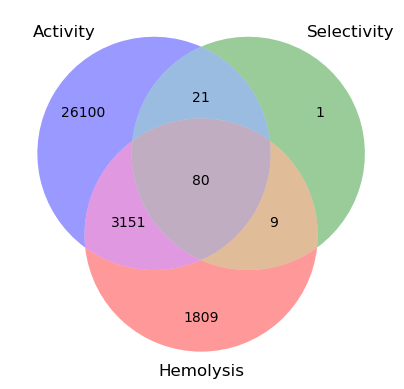

In [24]:
# Define the sets as lists of elements
set1 = set(results.query('MBC_8_prob == 100')['ID'].values)
set2 = set(results.query('selectivity_pred < 0.5')['ID'].values)
set3 = set(results.query('hemolysis_pred <= 2')['ID'].values)

# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
#plt.savefig('MBC_HEMO_SEL_2mut_venn3_predictions_v03.png')
plt.show()

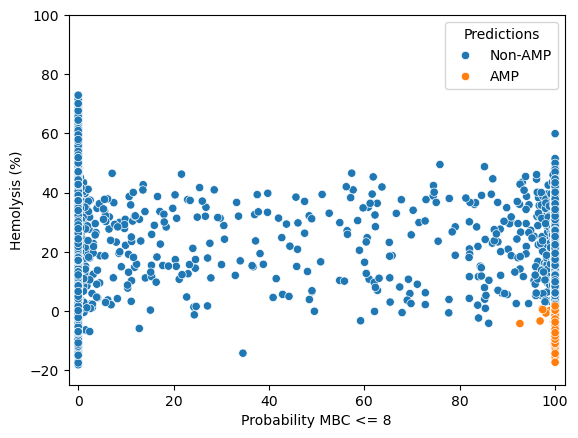

In [25]:
color1 = results.apply(lambda x: 'AMP' if x['MBC_8_prob'] > 90 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='MBC_8_prob', y='hemolysis_pred', hue=color1)
plt.xlabel('Probability MBC <= 8')
plt.ylabel('Hemolysis (%)')
plt.legend(loc='upper center')
plt.legend(title= "Predictions")
plt.ylim(-25,100)
plt.xlim(-2,102)
plt.show()

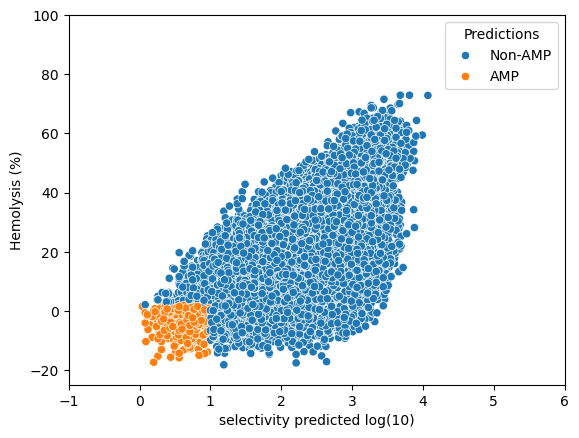

In [26]:
color2 = results.apply(lambda x: 'AMP' if x['selectivity_pred'] < 1 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='selectivity_pred', y='hemolysis_pred', hue=color2)
plt.ylabel('Hemolysis (%)')
plt.xlabel('selectivity predicted log(10)')
plt.legend(loc='upper right')
plt.ylim(-25,100)
plt.xlim(-1,6)
plt.legend(title= "Predictions")
plt.show()

In [27]:
# saving results
#results.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_2mut.csv')

## Predictions on triple mutant Protegrin-1 Variants

In [28]:
### Those functions will be used to predict the triple mutants in a loop
def run_GNB(features):    
    # creates a df to save probabilities
    res_GNB = pd.DataFrame()

    # calculates the probability of being active
    prob= model_GNB_mbc.predict_proba(features)
    prob= [(x[1]*100).round(2) for x in prob]
    
    res_GNB['ID']=features.index
    res_GNB['MBC_8_prob']=prob

    return res_GNB

In [29]:
### Predicting selectivity score
def run_SVR_sel(features, corr_columns):
    # creates a df to selectivity score
    res_sel = pd.DataFrame()

    # calculates the the selectivity score
    prob= model_SVR_sel.predict(features[corr_columns])

    res_sel['ID']=features.index
    res_sel['selectivity_pred']= prob.round(2) 

    return res_sel

In [30]:
### Prediction nom Hemolitic variants (hemolysis% < 2%)
def run_SVR_hemo(features, corr_columns):
    # creates a df to save hemolysis score
    res_hemo = pd.DataFrame()

    # calculates the the hemolysis score
    pred= model_SVR_hemo.predict(features[corr_columns])

    res_hemo['ID']=features.index
    res_hemo['hemolysis_pred']= pred.round(2)

    return res_hemo

### Preprocess the embedding from a tensor file to a lighter pickle file

In [31]:
# import multiprocessing

# # this was required to load the embeddings with multiple CPUs due the large file sizes
# for i in range(1,7):
#     '''this loop will load the embeddings with multiple CPUs and save them in a pickle file'''

#     # Set the directory containing the Torch files
#     data_dir = f'data/embedding/esm2_15B_pg1_3mut/esm2_15B_pg1_3mut_{i}mil/'

#     # Define the function to load a Torch file
#     def load_torch_file(filename):
#         filepath = os.path.join(data_dir, filename)
#         label = filename.split('.pt')[0]
#         embeddings = {}
#         embeddings[label] = np.array(torch.load(filepath)['mean_representations'][48])
#         return embeddings

#     # Get a list of all the Torch files in the directory
#     file_list = os.listdir(data_dir)

#     # Define the number of processes to use
#     num_processes = 50

#     # Create a multiprocessing pool with the number of processes defined above
#     pool = multiprocessing.Pool(processes=num_processes)

#     # Use the pool to load all the Torch files in parallel
#     results = pool.map(load_torch_file, file_list)

#     # Close the pool
#     pool.close()

#     # Concatenate the results into a single list
#     all_data = {k: v for d in results for k, v in d.items()}

#     # Convert the dictionary to a NumPy array
#     arr = np.array(list(all_data.values()))

#     # Set the keys as the index
#     index = list(all_data.keys())

#     # Create a DataFrame from the array
#     df = pd.DataFrame(arr, index=index)

#     # Print the DataFrame and renamed it
#     df.to_pickle(f'data/embedding/esm2_15B_pg1_3mut_{i}mil.pkl')

### Loaning the pre processced embedding from a pickle file and run prediction on each splited file
I have to split the files in 6 parts due its huge size

In [32]:
# read the CSV files and concatenate them row-wise
predictions = pd.DataFrame()

for i in range(1, 7):
    file_path = f'data/embedding/esm2_15B_pg1_3mut_{i}mil.pkl'
    features = pd.read_pickle(file_path)
    print(f'Processing file esm2_15B_pg1_3mut_{i}mil, size: {features.shape}')
    
    res_GNB = run_GNB(features)
    res_sel = run_SVR_sel(features, corr_columns_sel)
    res_hemo = run_SVR_hemo(features, corr_columns_hemo)
    
    res = res_GNB.merge(res_sel[['ID', 'selectivity_pred']], how='inner', left_on='ID', right_on='ID')
    res = res.merge(res_hemo[['ID', 'hemolysis_pred']], how='inner', left_on='ID', right_on='ID')

    predictions = pd.concat([predictions, res], axis=0).reset_index(drop=True)
    print(f'Prediction size: {predictions.shape[0]}')

predictions

Processing file esm2_15B_pg1_3mut_1mil, size: (1000000, 5120)
Prediction size: 1000000
Processing file esm2_15B_pg1_3mut_2mil, size: (1000000, 5120)
Prediction size: 2000000
Processing file esm2_15B_pg1_3mut_3mil, size: (1000000, 5120)
Prediction size: 3000000
Processing file esm2_15B_pg1_3mut_4mil, size: (1000000, 5120)
Prediction size: 4000000
Processing file esm2_15B_pg1_3mut_5mil, size: (1000000, 5120)
Prediction size: 5000000
Processing file esm2_15B_pg1_3mut_6mil, size: (652520, 5120)
Prediction size: 5652520


,ID,MBC_8_prob,selectivity_pred,hemolysis_pred
0,PG1_3mut_602975,100.0,1.48,10.07
1,PG1_3mut_185031,100.0,2.66,11.14
2,PG1_3mut_332050,100.0,1.33,8.96
3,PG1_3mut_938612,0.0,2.47,34.90
4,PG1_3mut_894404,0.0,2.49,11.92
...,...,...,...,...
5652515,PG1_3mut_5154857,0.0,1.72,16.58
5652516,PG1_3mut_5261581,100.0,2.86,12.41
5652517,PG1_3mut_5406149,0.0,2.44,13.42
5652518,PG1_3mut_5061684,100.0,2.47,13.23


## Load meta data and merge with results

In [34]:
meta_data = pd.read_csv('data/protegrin_variants_3mut.csv', index_col=0)
results = meta_data.merge(predictions, how='inner', left_on='ID', right_on='ID')
results

,ID,Sequence,MBC_8_prob,selectivity_pred,hemolysis_pred
0,PG1_3mut_0,HGGRLCYCRRRFCVCQTR,100.00,0.80,22.90
1,PG1_3mut_1,RGGQLCYVRRRFCVAVGR,100.00,1.77,-0.74
2,PG1_3mut_2,RCYRLCRCRRRFCVCVGR,0.00,2.33,25.24
3,PG1_3mut_3,RGSRLCYCRRRFCMCVIR,0.00,2.27,44.57
4,PG1_3mut_4,RGGRRCYCWRAFCVCVGR,0.00,2.77,38.32
...,...,...,...,...,...
5652515,PG1_3mut_5652515,RGIRLCYCERRSCVCVGR,87.85,2.19,21.35
5652516,PG1_3mut_5652516,RGGRLCACRRLFCVCVGV,0.00,3.17,-1.66
5652517,PG1_3mut_5652517,RGGDLCLCLRRFCVCVGR,0.00,3.23,8.40
5652518,PG1_3mut_5652518,FGGRLCYCRRRFCQGVGR,0.00,1.56,1.48


In [35]:
# saving results
#results.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_3mut.csv')

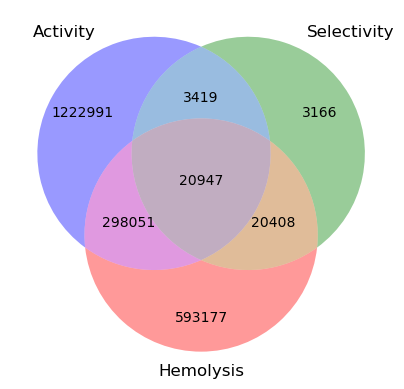

In [36]:
# Define the sets as lists of elements
set1 = set(results.query('MBC_8_prob == 100')['ID'].values)
set2 = set(results.query('selectivity_pred < 0.5')['ID'].values)
set3 = set(results.query('hemolysis_pred <= 2')['ID'].values)

# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
plt.show()

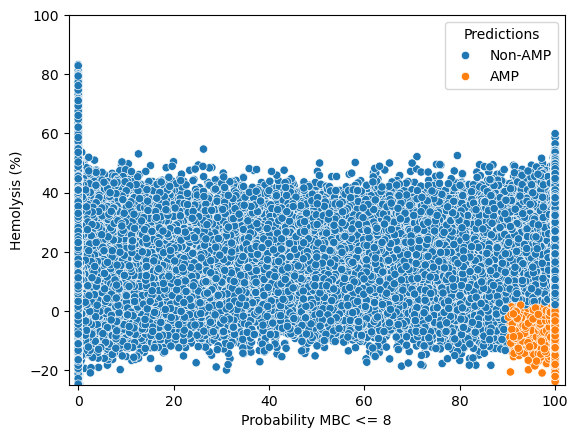

In [37]:
color1 = results.apply(lambda x: 'AMP' if x['MBC_8_prob'] > 90 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='MBC_8_prob', y='hemolysis_pred', hue=color1)
plt.xlabel('Probability MBC <= 8')
plt.ylabel('Hemolysis (%)')
plt.legend(loc='upper center')
plt.legend(title= "Predictions")
plt.ylim(-25,100)
plt.xlim(-2,102)
plt.show()

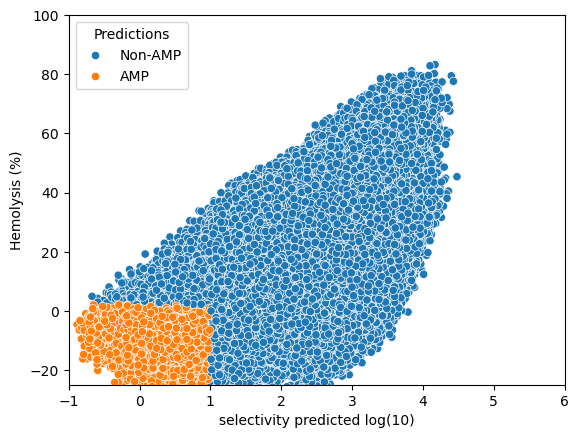

In [38]:
color2 = results.apply(lambda x: 'AMP' if x['selectivity_pred'] < 1 and x['hemolysis_pred'] <=2 else 'Non-AMP', axis=1).values

sns.scatterplot(data=results, x='selectivity_pred', y='hemolysis_pred', hue=color2)
plt.ylabel('Hemolysis (%)')
plt.xlabel('selectivity predicted log(10)')
plt.legend(loc='upper right')
plt.ylim(-25,100)
plt.xlim(-1,6)
plt.legend(title= "Predictions")
plt.show()

# Merge predictions and visualization

In [39]:
# loop trhrough the 3 predictions files and concatenate them
files = []
for i in range(1, 4):
    file = pd.read_csv(f'results/predictions_MIC_SEL_HEMO_models_PG1_{i}mut.csv', index_col=0)
    files.append(file)

data = pd.concat(files, axis=0)
data

,ID,Sequence,MBC_8_prob,selectivity_pred,hemolysis_pred
0,1mut_0,RGGRLCYCRRRFCVLVGR,100.00,1.71,8.30
1,1mut_1,RMGRLCYCRRRFCVCVGR,100.00,2.35,34.50
2,1mut_2,RGGRLCYCRRRFCVCVFR,0.00,2.89,39.31
3,1mut_3,EGGRLCYCRRRFCVCVGR,100.00,2.31,30.70
4,1mut_4,RGGNLCYCRRRFCVCVGR,100.00,2.32,32.25
...,...,...,...,...,...
5652515,PG1_3mut_5652515,RGIRLCYCERRSCVCVGR,87.85,2.19,21.35
5652516,PG1_3mut_5652516,RGGRLCACRRLFCVCVGV,0.00,3.17,-1.66
5652517,PG1_3mut_5652517,RGGDLCLCLRRFCVCVGR,0.00,3.23,8.40
5652518,PG1_3mut_5652518,FGGRLCYCRRRFCQGVGR,0.00,1.56,1.48


In [51]:
## save the file compressed
#data.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut.csv.gz', index=False, compression='gzip')
## lOAD the file
#data = pd.read_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut.csv.gz', compression='gzip')

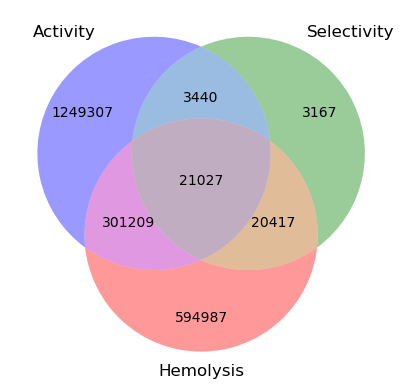

In [40]:
#Define the sets as lists of elements
set1 = set(data.query('MBC_8_prob == 100')['ID'].values)
set2 = set(data.query('selectivity_pred < 0.5')['ID'].values)
set3 = set(data.query('hemolysis_pred <= 2')['ID'].values)


# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))
#plt.savefig('results/MBC_HEMO_SEL_all_mutations_venn3_predictions_most_active.png')

plt.show()

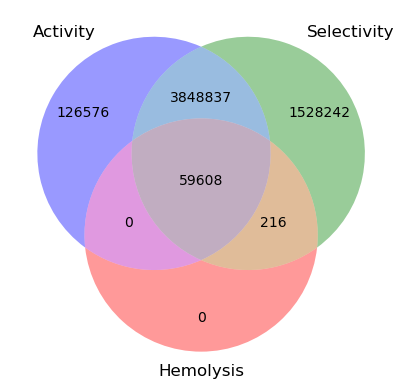

In [41]:
#Define the sets as lists of elements
set1 = set(data.query('MBC_8_prob == 0')['ID'].values)
set2 = set(data.query('selectivity_pred > 1')['ID'].values)
set3 = set(data.query('hemolysis_pred > 50')['ID'].values)


# Create the Venn diagram
venn3_unweighted([set1, set2, set3], set_labels=('Activity', 'Selectivity', 'Hemolysis'), set_colors=('b', 'g', 'r'))

#plt.savefig('results/MBC_HEMO_SEL_all_mutations_venn3_predictions_least_active.png')

plt.show()

In [42]:
### Most active
most_act = data.query('MBC_8_prob == 100 and selectivity_pred < 0.5 and hemolysis_pred <=2').copy()

### Least active
least_act = data.query('MBC_8_prob == 0 and selectivity_pred > 1 and hemolysis_pred > 50').copy()

print(f"Number of peptides: {most_act.shape[0]}")
print(f"Number of peptides: {least_act.shape[0]}")

Number of peptides: 21027
Number of peptides: 59608


### AA frequency change in most active peptides

In [43]:
# def to find the differences between the residues
idx = "RRRRICYCPLRFYVCVGR"

def diff_func(idxx):
    pg1 = "RGGRLCYCRRRFCVCVGR"
    idx = idxx
    diff = []
    for i in range(0, len(pg1)):
        aa = idx[i]
        pg_aa = pg1[i]
        
        if pg_aa == aa:
            diff.append("-")
        else:
            diff.append(aa)
    diff_seq = "".join(diff)
    return diff_seq


diff_func(idx)

'-RR-I---PL--Y-----'

In [44]:
most_act["difference_in_seq"] = [diff_func(x) for x in most_act["Sequence"]]
most_act

,ID,Sequence,MBC_8_prob,selectivity_pred,hemolysis_pred,difference_in_seq
1553,2mut_1553,RGGRLPYCRRRFCVTVGR,100.0,0.32,-4.30,-----P--------T---
3438,2mut_3438,RGGRLCYCRRRFCQTVGR,100.0,0.32,-1.91,-------------QT---
4990,2mut_4990,RGGRLTYCRRRFCVNVGR,100.0,0.48,-4.45,-----T--------N---
5247,2mut_5247,RGGRLCYCRRRFRVAVGR,100.0,0.44,-1.57,------------R-A---
6741,2mut_6741,RGGRLCYCRRRFCVARGR,100.0,0.20,0.06,--------------AR--
...,...,...,...,...,...,...
5650737,PG1_3mut_5650737,RGGRLAYCRRRFCVSVGR,100.0,0.49,-1.91,-----A--------S---
5651458,PG1_3mut_5651458,RGGRLCNTRRRFCVQVGR,100.0,0.24,-12.65,------NT------Q---
5651893,PG1_3mut_5651893,RGGRTCYCRRRFSVGVGR,100.0,0.41,-5.40,----T-------S-G---
5652044,PG1_3mut_5652044,RTGRLCYCRRRFTKCVGR,100.0,0.47,-2.18,-T----------TK----


In [45]:
diff = most_act["difference_in_seq"].str.split("", n= -1, expand = True)
most_act = most_act.merge(diff, left_index=True, right_index=True)
most_act

,ID,Sequence,MBC_8_prob,selectivity_pred,hemolysis_pred,difference_in_seq,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
1553,2mut_1553,RGGRLPYCRRRFCVTVGR,100.0,0.32,-4.30,-----P--------T---,,-,-,-,-,-,P,-,-,-,-,-,-,-,-,T,-,-,-,
3438,2mut_3438,RGGRLCYCRRRFCQTVGR,100.0,0.32,-1.91,-------------QT---,,-,-,-,-,-,-,-,-,-,-,-,-,-,Q,T,-,-,-,
4990,2mut_4990,RGGRLTYCRRRFCVNVGR,100.0,0.48,-4.45,-----T--------N---,,-,-,-,-,-,T,-,-,-,-,-,-,-,-,N,-,-,-,
5247,2mut_5247,RGGRLCYCRRRFRVAVGR,100.0,0.44,-1.57,------------R-A---,,-,-,-,-,-,-,-,-,-,-,-,-,R,-,A,-,-,-,
6741,2mut_6741,RGGRLCYCRRRFCVARGR,100.0,0.20,0.06,--------------AR--,,-,-,-,-,-,-,-,-,-,-,-,-,-,-,A,R,-,-,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5650737,PG1_3mut_5650737,RGGRLAYCRRRFCVSVGR,100.0,0.49,-1.91,-----A--------S---,,-,-,-,-,-,A,-,-,-,-,-,-,-,-,S,-,-,-,
5651458,PG1_3mut_5651458,RGGRLCNTRRRFCVQVGR,100.0,0.24,-12.65,------NT------Q---,,-,-,-,-,-,-,N,T,-,-,-,-,-,-,Q,-,-,-,
5651893,PG1_3mut_5651893,RGGRTCYCRRRFSVGVGR,100.0,0.41,-5.40,----T-------S-G---,,-,-,-,-,T,-,-,-,-,-,-,-,S,-,G,-,-,-,
5652044,PG1_3mut_5652044,RTGRLCYCRRRFTKCVGR,100.0,0.47,-2.18,-T----------TK----,,-,T,-,-,-,-,-,-,-,-,-,-,T,K,-,-,-,-,


## Heat map

In [46]:
# charged->polar->aliphatic->aromatic->other
aa_list = ['H', 'K', 'R', 'D', 'E', 'N', 'Q', 'S', 'T', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y','G', 'C', 'P']

#aa_list = ['H', 'K', 'R', 'D', 'E', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y', 'N', 'Q', 'S', 'T', 'G', 'C', 'P']
mtx = pd.DataFrame(0, index=aa_list, columns=np.arange(1, 19))

# fill the matix with the count of each amino acid in each position
for i in range(1, 19):
    pos_count = most_act[i].value_counts().to_dict()

    for k,v in pos_count.items():
        if k != '-':
            mtx.loc[k,i] = v

mtx

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
H,25,56,2,1,87,382,269,204,12,4,6,108,206,227,775,191,23,22
K,0,0,1,2,54,173,281,10,5,0,7,10,52,267,130,187,10,22
R,0,164,200,0,218,1012,670,452,0,0,0,178,440,637,861,810,86,0
D,12,194,70,5,242,499,772,189,58,59,14,506,330,394,803,310,48,1
E,1,15,3,0,86,397,260,69,2,0,2,50,44,115,295,79,4,0
N,7,89,40,6,168,343,834,204,23,18,12,550,725,770,1734,380,117,29
Q,43,74,67,28,278,838,665,301,44,48,88,178,244,444,933,552,53,42
S,3,23,4,0,132,493,196,62,1,5,1,129,179,216,996,205,33,0
T,50,289,71,53,817,973,1461,504,114,121,102,877,817,1812,3987,898,490,73
A,82,149,73,43,789,1141,546,385,112,60,106,846,561,847,2250,400,137,15


<Axes: >

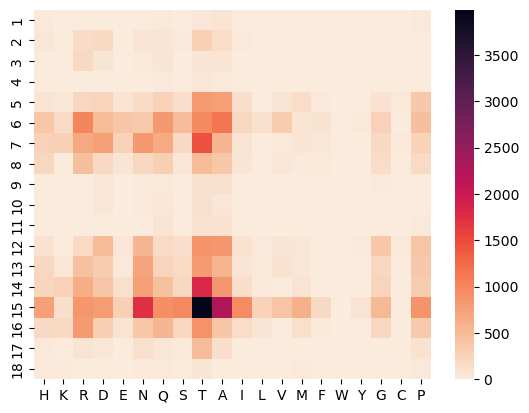

In [47]:
sns.heatmap(mtx.T, cmap="rocket_r")
#plt.savefig('results/changes_heatmap_predictions_ALL_mut_most_active.png', dpi=1200)

### AA frequency change in least active peptides

In [48]:
least_act["difference_in_seq"] = [diff_func(x) for x in least_act["Sequence"]]

diff = least_act["difference_in_seq"].str.split("", n= -1, expand = True)

least_act =least_act.merge(diff, left_index=True, right_index=True)

least_act

,ID,Sequence,MBC_8_prob,selectivity_pred,hemolysis_pred,difference_in_seq,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
68,2mut_68,RKGRLCYCRRWFCVCVGR,0.0,3.12,51.80,-K--------W-------,,-,K,-,-,-,-,-,-,-,-,W,-,-,-,-,-,-,-,
148,1mut_148,RGLRLCYCRRRFCVCVGR,0.0,2.99,50.61,--L---------------,,-,-,L,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,
159,1mut_159,RGFRLCYCRRRFCVCVGR,0.0,3.17,55.68,--F---------------,,-,-,F,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,
281,PG1_3mut_281,RWGRLCYCRRRFCSCVGW,0.0,3.35,53.34,-W-----------S---W,,-,W,-,-,-,-,-,-,-,-,-,-,-,S,-,-,-,W,
298,2mut_298,RGYRLCYCRRWFCVCVGR,0.0,3.21,60.59,--Y-------W-------,,-,-,Y,-,-,-,-,-,-,-,W,-,-,-,-,-,-,-,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5652264,PG1_3mut_5652264,KGGRLCYCRRTFCVCVGW,0.0,3.04,51.57,K---------T------W,,K,-,-,-,-,-,-,-,-,-,T,-,-,-,-,-,-,W,
5652321,PG1_3mut_5652321,RVWRLCYCRRGFCVCVGR,0.0,3.02,54.77,-VW-------G-------,,-,V,W,-,-,-,-,-,-,-,G,-,-,-,-,-,-,-,
5652352,PG1_3mut_5652352,PGFRLCYCVRRFCVCVGR,0.0,3.33,53.60,P-F-----V---------,,P,-,F,-,-,-,-,-,V,-,-,-,-,-,-,-,-,-,
5652399,PG1_3mut_5652399,RGWRLCYCRRKFCVCVGK,0.0,3.18,58.63,--W-------K------K,,-,-,W,-,-,-,-,-,-,-,K,-,-,-,-,-,-,K,


In [49]:
# charged->polar->aliphatic->aromatic->other
aa_list = ['H', 'K', 'R', 'D', 'E', 'N', 'Q', 'S', 'T', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y','G', 'C', 'P']

#aa_list = ['H', 'K', 'R', 'D', 'E', 'A', 'I', 'L', 'V', 'M', 'F', 'W', 'Y', 'N', 'Q', 'S', 'T', 'G', 'C', 'P']
mtx = pd.DataFrame(0, index=aa_list, columns=np.arange(1, 19))

# fill the matix with the count of each amino acid in each position
for i in range(1, 19):
    pos_count = least_act[i].value_counts().to_dict()

    for k,v in pos_count.items():
        if k != '-':
            mtx.loc[k,i] = v

mtx

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
H,220,330,670,522,599,1,29,0,1015,300,817,76,0,128,0,285,703,468
K,736,672,627,1360,705,1,69,0,917,913,894,76,3,30,0,241,1203,350
R,0,336,396,0,346,0,11,0,0,0,0,18,0,14,0,201,1345,0
D,161,211,176,184,33,0,0,0,386,22,170,0,0,2,0,65,198,237
E,447,149,280,630,190,0,5,0,459,97,336,3,0,8,0,117,283,235
N,536,610,484,426,178,0,32,0,1850,172,609,8,1,12,0,156,873,534
Q,276,125,129,276,121,0,2,0,316,113,188,2,0,12,0,75,248,85
S,599,450,665,518,324,1,18,0,720,163,530,16,0,52,0,377,329,412
T,357,309,825,663,272,0,17,0,1116,92,492,9,0,71,0,321,551,247
A,312,201,382,445,121,5,5,0,256,234,289,8,0,52,0,185,409,98


<Axes: >

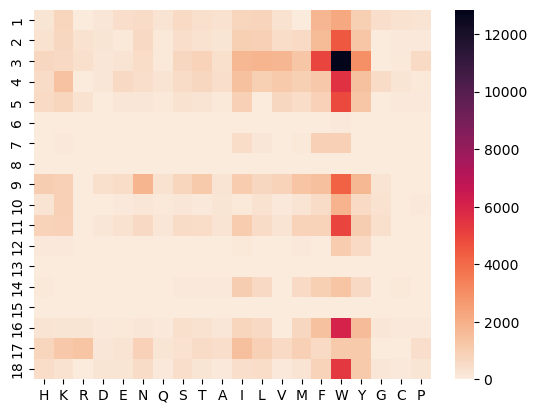

In [50]:
sns.heatmap(mtx.T, cmap="rocket_r")
#plt.savefig('results/changes_heatmap_predictions_ALL_mut_least_active_3.png' , dpi=1200)

# Validation

In [3]:
data = pd.read_excel('data/pg1_muts_validation_set.xlsx')
data.rename(columns={'Unnamed: 0': 'ID2'}, inplace=True)
#data['selectivity_true'] = np.where((data['MIC MH'] <= 8) & (data['%hemo'] <= 2), 1, 0)
data

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,selectivity
0,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,PG1_3mut_1739000,<-0.25,16,0.428850,0.836425,6.861598
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4,0.341131,0.134981,1.364522
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,>64,-0.165692,NaN,NaN
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64,0.165692,1.025482,10.604288
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8,0.721248,0.761174,5.769981
5,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,PG1_3mut_1210489,<-0.25,16,0.735867,1.070920,11.773879
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2,0.906433,0.258366,1.812865
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16,0.043860,-0.153815,0.701754
8,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,PG1_3mut_1980555,<-0.25,32,0.116959,0.573184,3.742690
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64,0.092593,0.772756,5.925926


In [4]:
# lOAD the file
predictions = pd.read_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut.csv.gz', compression='gzip')
predictions

,ID,Sequence,MBC_8_prob,selectivity_pred,hemolysis_pred
0,1mut_0,RGGRLCYCRRRFCVLVGR,100.00,1.71,8.30
1,1mut_1,RMGRLCYCRRRFCVCVGR,100.00,2.35,34.50
2,1mut_2,RGGRLCYCRRRFCVCVFR,0.00,2.89,39.31
3,1mut_3,EGGRLCYCRRRFCVCVGR,100.00,2.31,30.70
4,1mut_4,RGGNLCYCRRRFCVCVGR,100.00,2.32,32.25
...,...,...,...,...,...
5708434,PG1_3mut_5652515,RGIRLCYCERRSCVCVGR,87.85,2.19,21.35
5708435,PG1_3mut_5652516,RGGRLCACRRLFCVCVGV,0.00,3.17,-1.66
5708436,PG1_3mut_5652517,RGGDLCLCLRRFCVCVGR,0.00,3.23,8.40
5708437,PG1_3mut_5652518,FGGRLCYCRRRFCQGVGR,0.00,1.56,1.48


In [5]:
preds = predictions[predictions.Sequence.isin(data.Sequence)]
cols = ['ID', 'MBC_8_prob', 'selectivity_pred', 'hemolysis_pred']
data = data.merge(preds[cols], how='inner', left_on='ID', right_on='ID')
data

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,selectivity,MBC_8_prob,selectivity_pred,hemolysis_pred
0,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,PG1_3mut_1739000,<-0.25,16,0.428850,0.836425,6.861598,100.0,-0.82,-3.26
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4,0.341131,0.134981,1.364522,100.0,-0.76,-9.08
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,>64,-0.165692,NaN,NaN,100.0,-0.65,-1.97
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64,0.165692,1.025482,10.604288,100.0,-0.56,-5.19
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8,0.721248,0.761174,5.769981,100.0,-0.44,-6.20
5,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,PG1_3mut_1210489,<-0.25,16,0.735867,1.070920,11.773879,100.0,-0.43,-9.15
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2,0.906433,0.258366,1.812865,100.0,-0.43,-6.51
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16,0.043860,-0.153815,0.701754,100.0,-0.40,-6.28
8,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,PG1_3mut_1980555,<-0.25,32,0.116959,0.573184,3.742690,100.0,-0.29,-12.57
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64,0.092593,0.772756,5.925926,100.0,-0.28,-3.90


In [49]:
#data.to_csv('results/predictions_MIC_SEL_HEMO_models_PG1_1-3mut_validation_set_v01.csv')

## Hemolysis

In [49]:
# Model evaluation on test data
hemo_true = data['%hemo']
hemo_pred = data['hemolysis_pred']

r2 = metrics.r2_score(hemo_true, hemo_pred)
mae = metrics.mean_absolute_error(hemo_true, hemo_pred)
print(f'R2: {r2}, MAE: {mae}')

from scipy.stats import spearmanr

# Calculate the Spearman correlation coefficient between x and y
corr, pval = spearmanr(hemo_true, hemo_pred)

# Print the correlation coefficient and p-value
print(f"Spearman correlation coefficient: {corr:.2f}")
print(f"P-value: {pval:.2f}")

R2: -4.790066480748846, MAE: 5.822203811999134
Spearman correlation coefficient: 0.27
P-value: 0.11


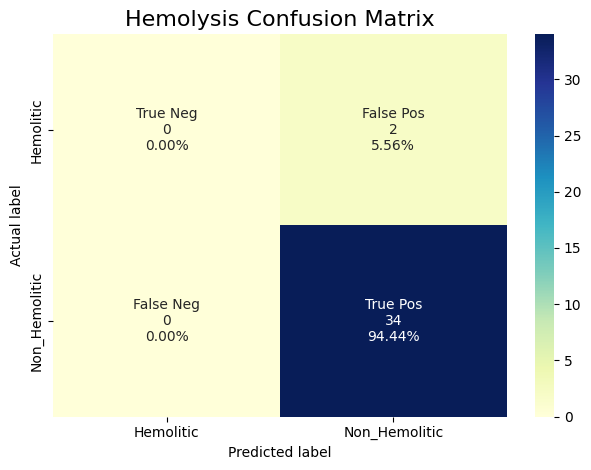

In [50]:
#confusion_matrix, 
true = [1 if x <=5 else 0 for x in hemo_true]
pred = [1 if x<=5 else 0 for x in hemo_pred]

conf_m = metrics.confusion_matrix(true, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Hemolitic', 'Non_Hemolitic']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Hemolysis Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [51]:
accuracy = metrics.accuracy_score(true, pred)
recall = metrics.recall_score(true, pred)
precision = metrics.precision_score(true, pred)
f1_score = metrics.f1_score(true, pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.94
Recall: 1.00
Precision: 0.94
F1 Score: 0.97


In [52]:
df = pd.DataFrame()
df_dict={'Version': 'V01', 'Feature': 'Hemolysis', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])
df

,Version,Feature,Accuracy,Recall,Precision,F1 Score
0,V01,Hemolysis,0.944444,1.0,0.944444,0.971429


## Selectivity

In [53]:
data2 = data[~data.L10Select.isna()]

# Model evaluation on test data
sel_true = data2['L10Select']
sel_pred = data2['selectivity_pred']

r2 = metrics.r2_score(sel_true, sel_pred)
mae = metrics.mean_absolute_error(sel_true, sel_pred)
print(f'R2: {r2}, MAE: {mae}')

from scipy.stats import spearmanr

# Calculate the Spearman correlation coefficient between x and y
corr, pval = spearmanr(sel_true, sel_pred)

# Print the correlation coefficient and p-value
print(f"Spearman correlation coefficient: {corr:.2f}")
print(f"P-value: {pval:.2f}")

R2: -3.5024301051715696, MAE: 0.9785903815798724
Spearman correlation coefficient: 0.35
P-value: 0.06


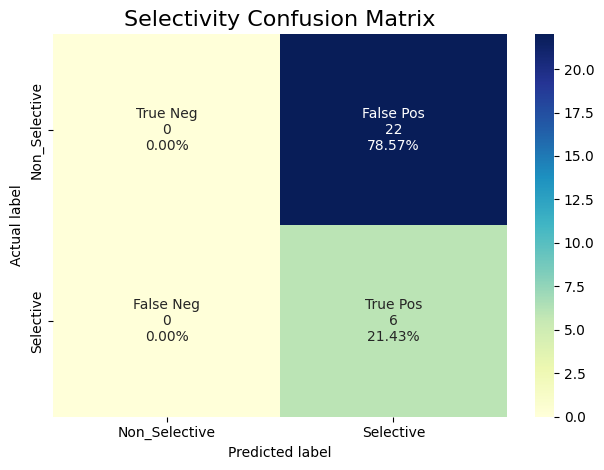

In [54]:
#confusion_matrix, 
true = [1 if x<0.5 else 0 for x in sel_true]
pred = [1 if x<0.5 else 0 for x in sel_pred]

conf_m = metrics.confusion_matrix(true, pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Non_Selective', 'Selective']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Selectivity Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [55]:
accuracy = metrics.accuracy_score(true, pred)
recall = metrics.recall_score(true, pred)
precision = metrics.precision_score(true, pred)
f1_score = metrics.f1_score(true, pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.21
Recall: 1.00
Precision: 0.21
F1 Score: 0.35


In [56]:
df_dict={'Version': 'V01', 'Feature': 'Selectivity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])
df

,Version,Feature,Accuracy,Recall,Precision,F1 Score
0,V01,Hemolysis,0.944444,1.0,0.944444,0.971429
0,V01,Selectivity,0.214286,1.0,0.214286,0.352941


## Activity

In [57]:
# This function wil convert the undefined MIC values or MIC > 8 to 0.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        return 0
    elif float(mic_value) > 8:
        return 0
    else:
        return 1

In [58]:
# Load meta data
data['MIC'] = [convert_mic(x) for x in data['MIC MH']]
data

,ID2,Sequence,RGGRLCYCRRRFCVCVGR,Select,Charge,ID,group,MIC MH,%hemo,L10Select,selectivity,MBC_8_prob,selectivity_pred,hemolysis_pred,MIC
0,bsPG-1.1,RGGRLQYCRRRFCVARGR,-----Q--------AR--,-0.82,6.742145,PG1_3mut_1739000,<-0.25,16,0.428850,0.836425,6.861598,100.0,-0.82,-3.26,0
1,bsPG-1.2,RGGRLQYCRRRGCVTVGR,-----Q-----G--T---,-0.76,5.742155,PG1_3mut_1218602,<-0.25,4,0.341131,0.134981,1.364522,100.0,-0.76,-9.08,1
2,bsPG-1.3,RGGRLAYCRRRDCTCVGR,-----A-----D-T----,-0.65,4.651497,PG1_3mut_1896424,CP,>64,-0.165692,NaN,NaN,100.0,-0.65,-1.97,0
3,bsPG-1.4,RGGRLDYCRRRFCVTTGR,-----D--------TT--,-0.56,4.742406,PG1_3mut_1275003,<-0.25,64,0.165692,1.025482,10.604288,100.0,-0.56,-5.19,0
4,bsPG-1.5,RGGRLQACRRRFCVTVGR,-----QA-------T---,-0.44,5.744660,PG1_3mut_257802,<-0.25,8,0.721248,0.761174,5.769981,100.0,-0.44,-6.20,1
5,bsPG-1.6,RGGRLRYCRRRFDVSVGR,-----R------D-S---,-0.43,5.833305,PG1_3mut_1210489,<-0.25,16,0.735867,1.070920,11.773879,100.0,-0.43,-9.15,0
6,bsPG-1.7,RGGRLCTARRRFCVRVGR,------TA------R---,-0.43,6.744650,PG1_3mut_1536372,<-0.25,2,0.906433,0.258366,1.812865,100.0,-0.43,-6.51,1
7,bsPG-1.8,RGGRLTYCRRRFCTAVGR,-----T-------TA---,-0.40,5.742155,PG1_3mut_1147726,<-0.25,16,0.043860,-0.153815,0.701754,100.0,-0.40,-6.28,0
8,bsPG-1.9,RGGRLTYCRRRDCVAVGR,-----T-----D--A---,-0.29,4.742406,PG1_3mut_1980555,<-0.25,32,0.116959,0.573184,3.742690,100.0,-0.29,-12.57,0
9,bsPG-1.10,RGGRLAYCRRRFCVDTGR,-----A--------DT--,-0.28,4.742406,PG1_3mut_1658870,<-0.25,64,0.092593,0.772756,5.925926,100.0,-0.28,-3.90,0


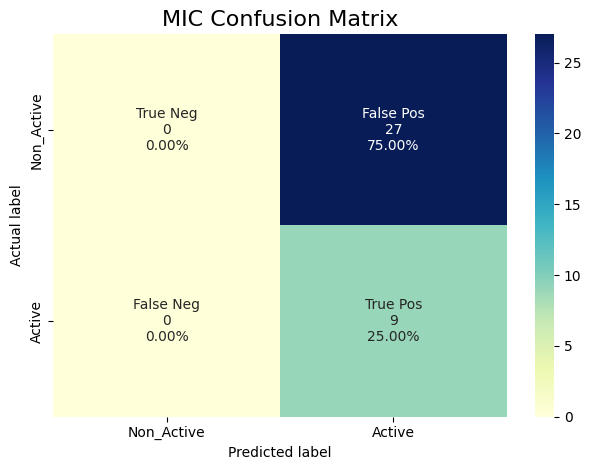

In [59]:
#confusion_matrix, 
mic_true = data['MIC']
mic_pred = [1 if x==100 else 0 for x in data['MBC_8_prob'] ]

conf_m = metrics.confusion_matrix(mic_true, mic_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Non_Active', 'Active']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('MIC Confusion Matrix', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [60]:
accuracy = metrics.accuracy_score(mic_true, mic_pred)
recall = metrics.recall_score(mic_true, mic_pred)
precision = metrics.precision_score(mic_true, mic_pred)
f1_score = metrics.f1_score(mic_true, mic_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.25
Recall: 1.00
Precision: 0.25
F1 Score: 0.40


In [61]:
df_dict={'Version': 'V01', 'Feature': 'Activity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.concat([df, pd.DataFrame(df_dict, index=[0])])
df

,Version,Feature,Accuracy,Recall,Precision,F1 Score
0,V01,Hemolysis,0.944444,1.0,0.944444,0.971429
0,V01,Selectivity,0.214286,1.0,0.214286,0.352941
0,V01,Activity,0.250000,1.0,0.250000,0.400000


In [63]:
#df.to_csv('results/model_v01_performance.csv', index=False)
df

,Version,Feature,Accuracy,Recall,Precision,F1 Score
0,V01,Hemolysis,0.944444,1.0,0.944444,0.971429
0,V01,Selectivity,0.214286,1.0,0.214286,0.352941
0,V01,Activity,0.250000,1.0,0.250000,0.400000


In [24]:
df_melted = pd.melt(df, 
        id_vars=['Version', 'Feature'],
        value_vars=['Accuracy', 'Recall', 'Precision', 'F1 Score'],
        var_name='Metric',
        value_name='Score')

df_melted= df_melted.sort_values(by=['Version', 'Feature', 'Metric']).reset_index(drop=True)
df_melted

,Version,Feature,Metric,Score
0,V01,Activity,Accuracy,0.250000
1,V01,Activity,F1 Score,0.400000
2,V01,Activity,Precision,0.250000
3,V01,Activity,Recall,1.000000
4,V01,Hemolysis,Accuracy,0.944444
5,V01,Hemolysis,F1 Score,0.971429
6,V01,Hemolysis,Precision,0.944444
7,V01,Hemolysis,Recall,1.000000
8,V01,Selectivity,Accuracy,0.214286
9,V01,Selectivity,F1 Score,0.352941


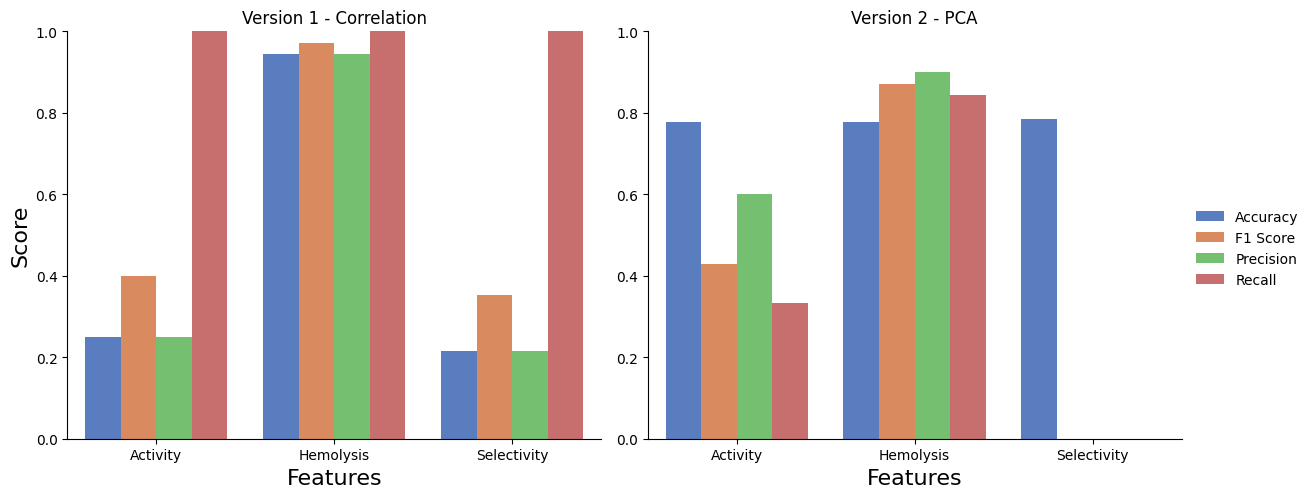

In [48]:
g = sns.FacetGrid(df_melted, col="Version", sharey=False, height=5, aspect=1.2, ylim=(0,1))#col_order=['Train_Accuracy', 'Test_Accuracy']
g.map_dataframe(sns.barplot, x="Feature", y="Score", hue='Metric', palette='muted')
g.set_axis_labels("Features", "Score", size=16)
#g.set_titles(col_template="{col_name}", row_template="{row_name}")
axes = g.axes.flatten()
axes[0].set_title("Version 1 - Correlation")
axes[1].set_title("Version 2 - PCA")

g.add_legend()
plt.show()